# Datathon AI X DATA: Vision Pillar (Spring 2025)

## Overview

### Competition Overview
The goal of this competition is to build or fine-tune a computer vision model to correctly classify sports video game images into one of five different sports genres: Basketball, Volleyball, Tennis, Soccer, and American Football. The contestants will be provided with a dataset consisting of video game images, along with a CSV file that maps the image filenames to their respective sports labels. Contestants will need to develop a model capable of identifying the sport category of each image.

## Import Libraries

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import os

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50  
from tensorflow.keras.optimizers import Adam

## Data Loading and Preprocessing

In [21]:
TRAIN_CSV_PATH = 'train.csv'
TEST_CSV_PATH = 'test.csv'
IMAGE_DIR = './'

In [22]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_df.sample(10)

,filename,class,id
402,images/403.jpg,Soccer,403
855,images/856.jpg,Volleyball,856
72,images/73.jpg,AmericanFootball,73
952,images/953.jpg,Volleyball,953
126,images/127.jpg,AmericanFootball,127
399,images/400.jpg,Basketball,400
591,images/592.jpg,Soccer,592
768,images/769.jpg,Tennis,769
878,images/879.jpg,Volleyball,879
475,images/476.jpg,Soccer,476


In [23]:
train_df['class'] = train_df['class'].astype(str)
class_counts = train_df['class'].value_counts()
print("Class Counts:\n", class_counts)

Class Counts:
 class
AmericanFootball    200
Basketball          200
Soccer              200
Tennis              200
Volleyball          200
Name: count, dtype: int64


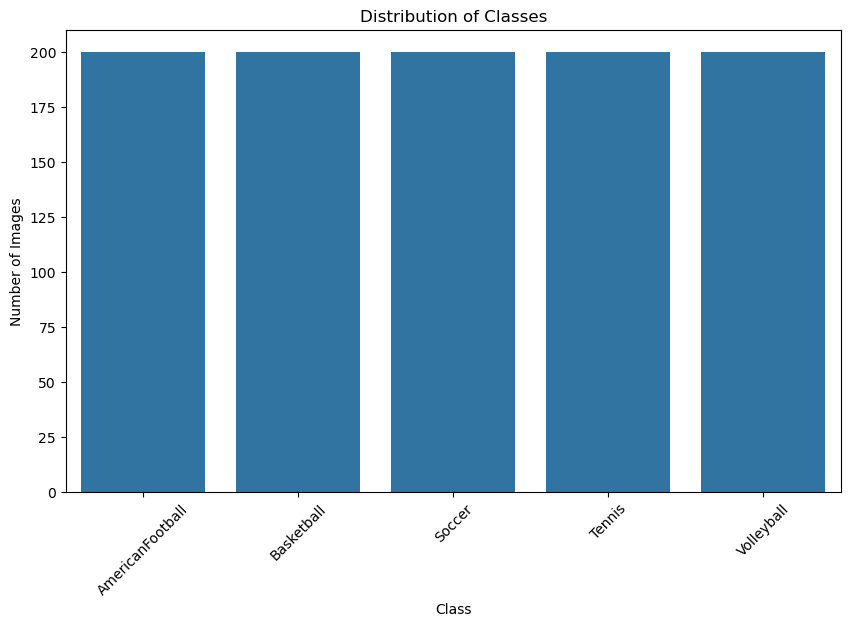

In [24]:
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()


Displaying images for class: AmericanFootball


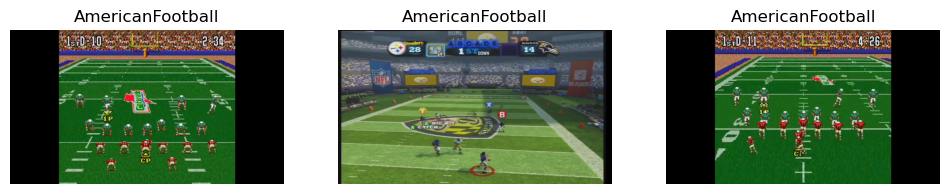

Displaying images for class: Basketball


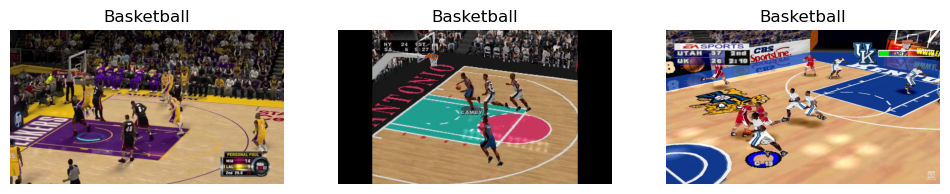

Displaying images for class: Soccer


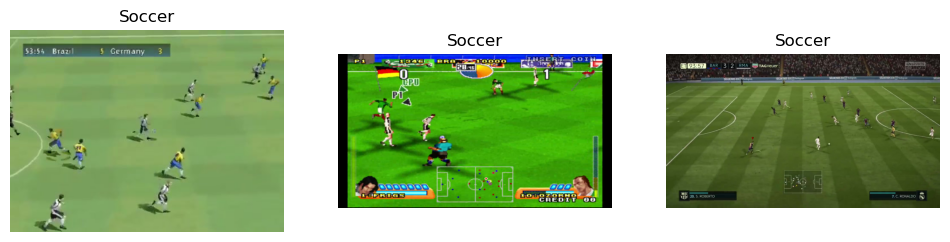

Displaying images for class: Tennis


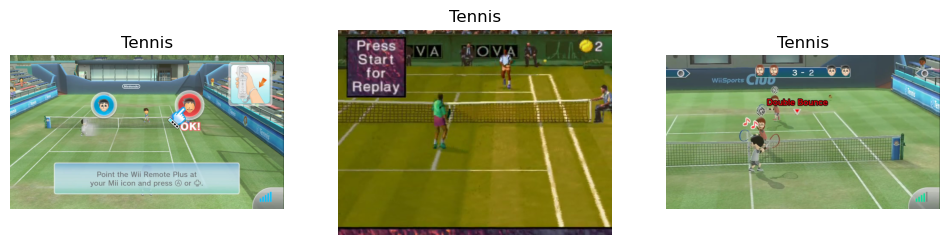

Displaying images for class: Volleyball


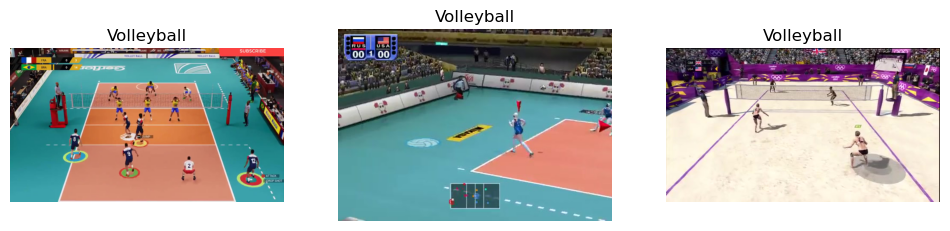

In [ ]:
from PIL import Image
import os

# Get unique class names
class_names = sorted(train_df['class'].unique())

# Display a few images from each class
for class_name in class_names:
    print(f"Displaying images for class: {class_name}")
    class_images = train_df[train_df['class'] == class_name]['filename'].sample(3) #get 3 first images of each class

    plt.figure(figsize=(12, 4))
    for i, image_path in enumerate(class_images):
        img = Image.open(os.path.join(IMAGE_DIR, image_path))
        plt.subplot(1, 3, i + 1)  # 1 row, 3 columns, index i+1
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')  
    plt.show()